# Severity Classification Models for Traffic Accidents
In this notebook, classification models for the severity of traffic crashes will be developed.

In [ ]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Capstone/'

%cd $abspath_curr

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Capstone


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from toolbox import *

## Read Dataset
The dataset is obtained from Chicago Data Potal.

In [ ]:
# Read the data
df_train = pd.concat([pd.read_csv(f"Data/train_smote_{i}.csv") for i in range(1, 5)], ignore_index=True)
df_val = pd.read_csv("Data/val.csv", index_col=False)
df_test = pd.read_csv("Data/test.csv", index_col=False)

### Model Development - Catboost

#### Hyperparameter Tuning

In [ ]:
df_train_x = df_train.drop(columns=["Severity"])
y_train = df_train["Severity"].values

df_val_x = df_val.drop(columns=["Severity"])
y_val = df_val["Severity"].values

df_test_x = df_test.drop(columns=["Severity"])
y_test = df_test["Severity"].values

In [ ]:
# Get  the position of categorical features
categorical_features = df_train_x.dtypes[df_train_x.dtypes==object].index
cat_pos = []
for i in range(len(df_train_x.columns)):
    if df_train_x.columns[i] in categorical_features:
        cat_pos.append(i)

In [ ]:
X_train_cat = df_train_x.values
X_val_cat = df_val_x.values
X_test_cat = df_test_x.values

In [ ]:
!pip install catboost

In [ ]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

from google.colab import output
output.enable_custom_widget_manager()

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


Tuning parameters: l2_leaf_reg = 1, 2, 3 and depth = 6, 8, 10.  
The model with l2_leaf_reg = 2 and depth = 10 showed the best performance in terms of F1 score.

In [ ]:
import catboost

params = {
    "iterations": 5000,
    "learning_rate": 0.1,
    "use_best_model": True,
    "eval_metric": 'TotalF1:average=Macro',
    "random_seed": 6501,
    "loss_function": 'MultiClass',
    "task_type": "GPU",
    "max_bin": 254,
    "subsample": 0.8,
    "bootstrap_type": "Bernoulli",
    "ctr_target_border_count": 2,
    "max_ctr_complexity": 4,
    "allow_writing_files": False,
    "logging_level": 'Silent'
    }

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def display_metrics(model, X, y):
  y_pred = model.predict(X)

  accuracy = accuracy_score(y, y_pred)
  recall = recall_score(y, y_pred, average='macro')
  precision = precision_score(y, y_pred, average='macro')
  f1 = f1_score(y, y_pred, average='macro')

  print("Accuracy:", accuracy)
  print("Recall:", recall)
  print("Precision:", precision)
  print("F1 Score:", f1)

In [ ]:
# depth=6, l2_leaf_reg=1
params.update({"depth": 6, "l2_leaf_reg": 1})
clf_cat1 = catboost.CatBoostClassifier(**params)

clf_cat1.fit(X_train_cat, y_train,
             cat_features=cat_pos,
             eval_set=(X_val_cat, y_val),
             plot=True)

display_metrics(clf_cat1, X_val_cat, y_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy: 0.7572236079168151
Recall: 0.4887245518574667
Precision: 0.4289643440599402
F1 Score: 0.4381930284475295


In [ ]:
# depth=6, l2_leaf_reg=2
params.update({"depth": 6, "l2_leaf_reg": 2})
clf_cat2 = catboost.CatBoostClassifier(**params)

clf_cat2.fit(X_train_cat, y_train,
             cat_features=cat_pos,
             eval_set=(X_val_cat, y_val),
             plot=True)

display_metrics(clf_cat2, X_val_cat, y_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy: 0.7568510900197597
Recall: 0.4881801260144976
Precision: 0.4288528279657342
F1 Score: 0.43784748642010074


In [ ]:
# depth=6, l2_leaf_reg=3
params.update({"depth": 6, "l2_leaf_reg": 3})
clf_cat3 = catboost.CatBoostClassifier(**params)

clf_cat3.fit(X_train_cat, y_train,
             cat_features=cat_pos,
             eval_set=(X_val_cat, y_val),
             plot=True)

display_metrics(clf_cat3, X_val_cat, y_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy: 0.7564866703378575
Recall: 0.4882487763307303
Precision: 0.4288783063449196
F1 Score: 0.4375651916276006


In [ ]:
# depth=8, l2_leaf_reg=1
params.update({"depth": 8, "l2_leaf_reg": 1})
clf_cat4 = catboost.CatBoostClassifier(**params)

clf_cat4.fit(X_train_cat, y_train,
             cat_features=cat_pos,
             eval_set=(X_val_cat, y_val),
             plot=True)

display_metrics(clf_cat4, X_val_cat, y_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy: 0.7777930744064008
Recall: 0.47179494576905645
Precision: 0.4308442444455222
F1 Score: 0.44143778262613426


In [ ]:
# depth=8, l2_leaf_reg=2
params.update({"depth": 8, "l2_leaf_reg": 2})
clf_cat5 = catboost.CatBoostClassifier(**params)

clf_cat5.fit(X_train_cat, y_train,
             cat_features=cat_pos,
             eval_set=(X_val_cat, y_val),
             plot=True)

display_metrics(clf_cat5, X_val_cat, y_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy: 0.7731932881992809
Recall: 0.47823376280606084
Precision: 0.4310674806375922
F1 Score: 0.4422781577144819


In [ ]:
# depth=8, l2_leaf_reg=3
params.update({"depth": 8, "l2_leaf_reg": 3})
clf_cat6 = catboost.CatBoostClassifier(**params)

clf_cat6.fit(X_train_cat, y_train,
             cat_features=cat_pos,
             eval_set=(X_val_cat, y_val),
             plot=True)

display_metrics(clf_cat6, X_val_cat, y_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy: 0.7758414045544362
Recall: 0.474254384604263
Precision: 0.4309697428236496
F1 Score: 0.44181548713236235


In [ ]:
# depth=10, l2_leaf_reg=1
params.update({"depth": 10, "l2_leaf_reg": 1})
clf_cat7 = catboost.CatBoostClassifier(**params)

clf_cat7.fit(X_train_cat, y_train,
             cat_features=cat_pos,
             eval_set=(X_val_cat, y_val),
             plot=True)

display_metrics(clf_cat7, X_val_cat, y_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy: 0.7962812996015678
Recall: 0.46115837730505643
Precision: 0.4362590510140578
F1 Score: 0.4453562395185036


In [ ]:
# depth=10, l2_leaf_reg=2
params.update({"depth": 10, "l2_leaf_reg": 2})
clf_cat8 = catboost.CatBoostClassifier(**params)

clf_cat8.fit(X_train_cat, y_train,
             cat_features=cat_pos,
             eval_set=(X_val_cat, y_val),
             plot=True)

display_metrics(clf_cat8, X_val_cat, y_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy: 0.7951880405558615
Recall: 0.46214377990672556
Precision: 0.4357817646760514
F1 Score: 0.44502273423679983


In [ ]:
# depth=10, l2_leaf_reg=3
params.update({"depth": 10, "l2_leaf_reg": 3})
clf_cat9 = catboost.CatBoostClassifier(**params)

clf_cat9.fit(X_train_cat, y_train,
             cat_features=cat_pos,
             eval_set=(X_val_cat, y_val),
             plot=True)

display_metrics(clf_cat9, X_val_cat, y_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy: 0.79147095980046
Recall: 0.4672328579002008
Precision: 0.4359105478903511
F1 Score: 0.4463856316240418


Training the model with best paramters and train and validation data.

In [ ]:
X_train_val_cat, y_train_val_cat, ps_cat = get_train_val_ps(X_train_cat, y_train, X_val_cat, y_val)
params.update({"depth": 10, "l2_leaf_reg": 3, "use_best_model": False})
clf_cat = catboost.CatBoostClassifier(**params)

clf_cat.fit(X_train_val_cat, y_train_val_cat,
             cat_features=cat_pos)

display_metrics(clf_cat, X_test_cat, y_test)

Accuracy: 0.8112645260557962
Recall: 0.4614351130756152
Precision: 0.446654014084463
F1 Score: 0.4520305001774027


In [ ]:
clf_cat.save_model('catboost_bestmodel.bin')

In [ ]:
# # Load the best model
# clf_cat = catboost.CatBoostClassifier()
# clf_cat.load_model('catboost_bestmodel.bin')

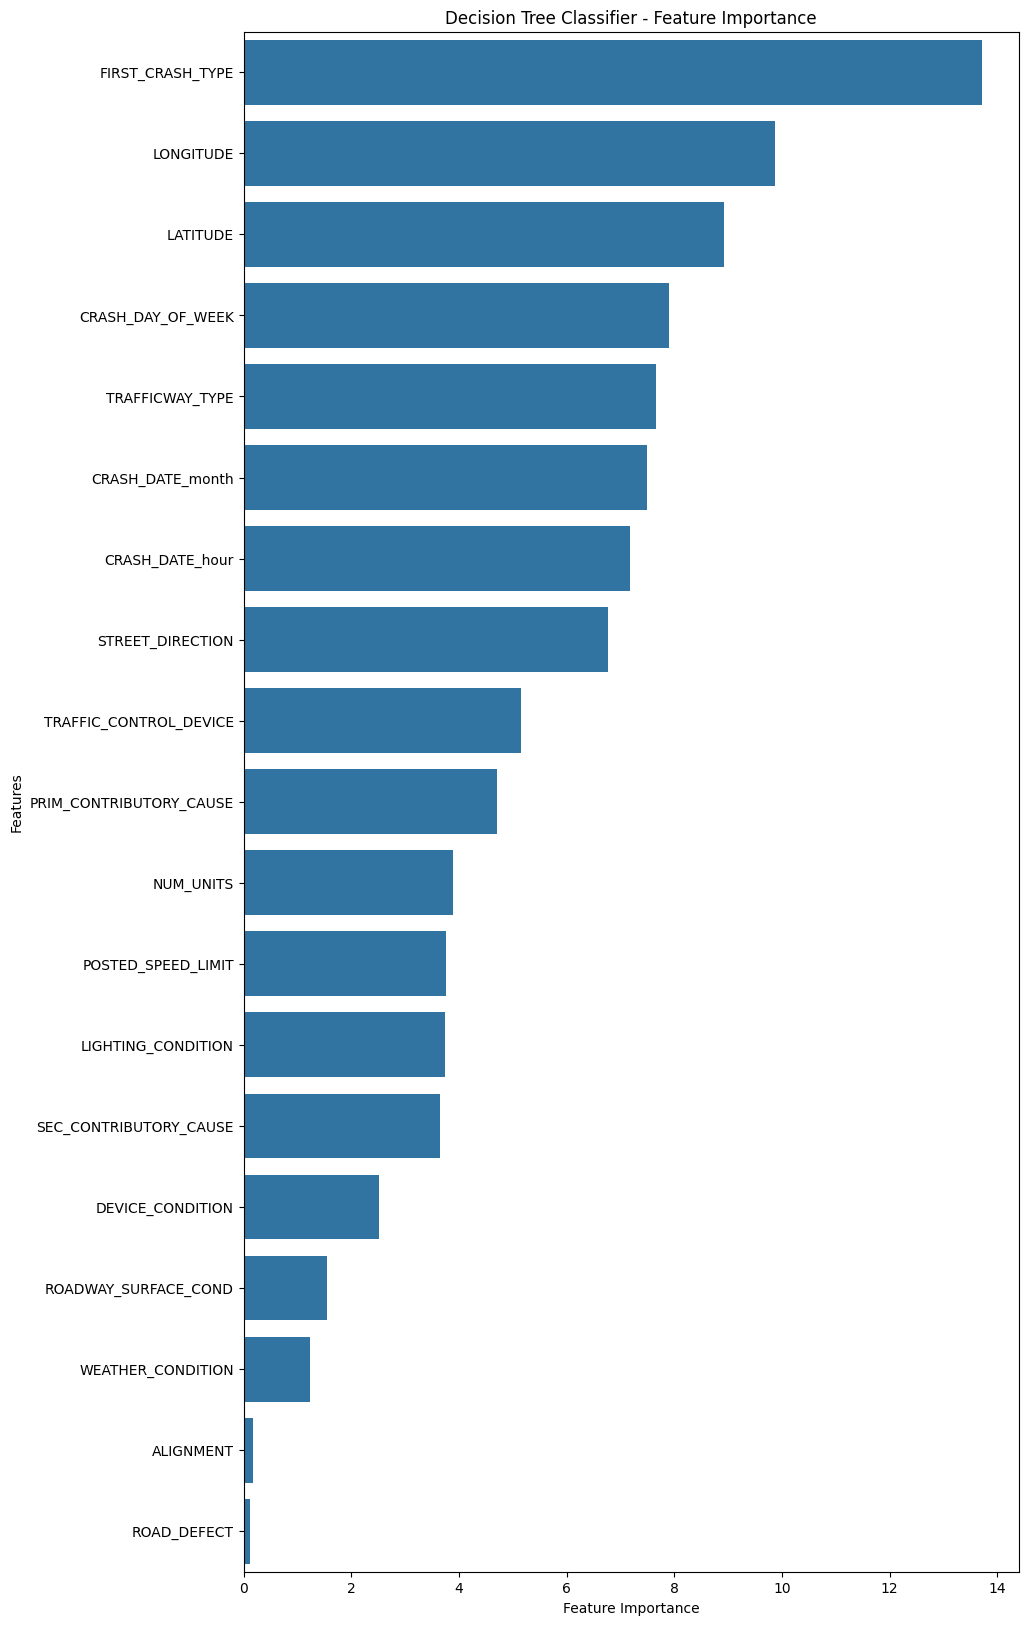

In [ ]:
importances = clf_cat.get_feature_importance()

indices = np.argsort(importances)[::-1]
sorted_features = [df_train_x.columns[i] for i in indices]
sorted_importances = importances[indices]

plt.figure(figsize=(10, 20))
sns.barplot(x=sorted_importances, y=sorted_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Decision Tree Classifier - Feature Importance')
plt.show()